# Quantum Fourier Transform

In [2]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

## Background QFT info

Fourier basis explanation

bloch sphere rotation in fourier vs computational

fourier summation derivation

unitary matrix form of fourier

Rotation gate

1-qubit qft (walk through circuit math)

## Algorithm
latex general circuit


### Proof
general math

show general circuit as function

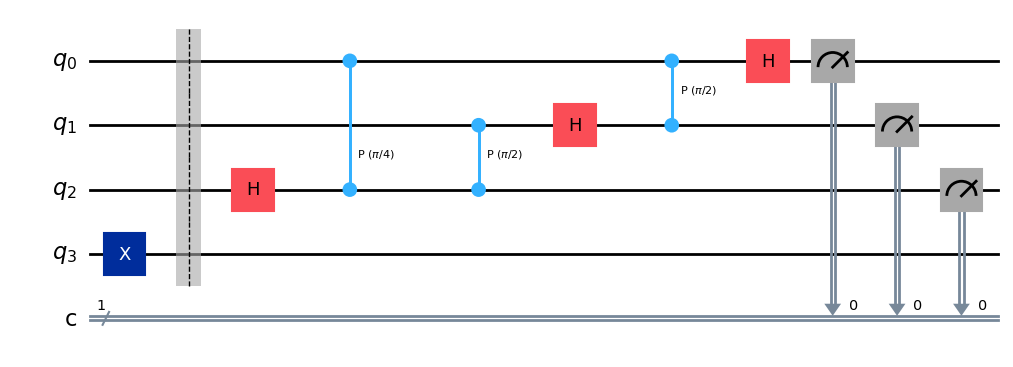

In [24]:
qc = QuantumCircuit(4,1)
qc.x(3)
qc.barrier()
qc.h(2)
qc.cp(pi/4,0,2)
qc.cp(pi/2,1,2)
qc.h(1)
qc.cp(pi/2,0,1)
qc.h(0)
#qc.swap(0,2)
qc.measure(0,0)
qc.measure(1,0)
qc.measure(2,0)
qc.draw('mpl')

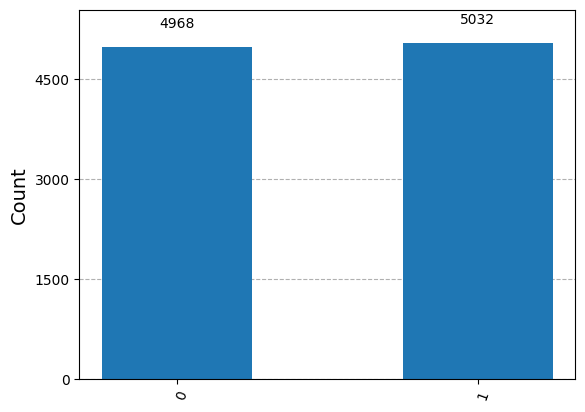

In [22]:
backend = BasicSimulator()

num_of_shots = 10000

result = backend.run(qc, shots=num_of_shots).result()   
counts = result.get_counts()                    
plot_histogram(counts)

### Verfication